In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

In [3]:
# Constants
root = '/content/drive/MyDrive/Brain Tumor/Brain Tumor'
IMAGE_DATASET = '/content/drive/MyDrive/Brain Tumor/Brain Tumor'
IMAGE_DATASET_RAW = r'/content/drive/MyDrive/Brain Tumor/Brain Tumor'
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS = 50

In [4]:
# import the csv file containing the features and the classes of the images
cortex_df = pd.read_csv("/content/drive/MyDrive/Brain Tumor.csv")
cortex_df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


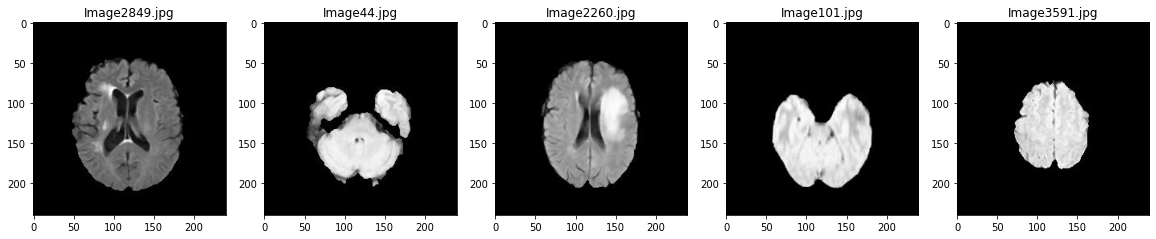

In [5]:
plt.figure(figsize=(20,20))
test_folder='/content/drive/MyDrive/Brain Tumor/Brain Tumor' 
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [6]:
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head()

,Image,Class,paths,pixels
0,Image1,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,/content/drive/MyDrive/Brain Tumor/Brain Tumor...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


In [7]:
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [8]:
y = np.array(dataset_df.Class)
y.shape

(3762,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


In [10]:
def model(input_shape):
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))  
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))    # Never use sigmoid for binary classification
    
    return model

In [11]:
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          1

In [13]:
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [14]:
# Training the model
history = model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=10)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


301/301 [==============================] - 35s 8ms/step - loss: 0.6133 - accuracy: 0.6843
Epoch 2/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4983 - accuracy: 0.7813
Epoch 3/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4661 - accuracy: 0.7973
Epoch 4/50
301/301 [==============================] - 2s 7ms/step - loss: 0.4364 - accuracy: 0.8029
Epoch 5/50
301/301 [==============================] - 2s 7ms/step - loss: 0.3982 - accuracy: 0.8259
Epoch 6/50
301/301 [==============================] - 2s 7ms/step - loss: 0.3582 - accuracy: 0.8395
Epoch 7/50
301/301 [==============================] - 2s 7ms/step - loss: 0.3378 - accuracy: 0.8538
Epoch 8/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2998 - accuracy: 0.8644
Epoch 9/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2748 - accuracy: 0.8810
Epoch 10/50
301/301 [==============================] - 2s 7ms/step - loss: 0.2666 - accuracy: 0.8800
Epoch 11/

In [15]:
model.save("BrainTumor")

INFO:tensorflow:Assets written to: BrainTumorv7/assets


In [16]:
loss = history.history["loss"]
acc = history.history["accuracy"]

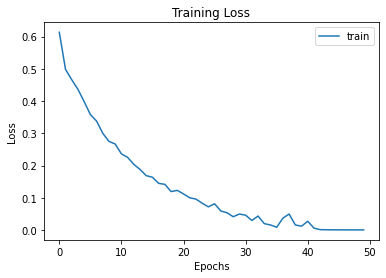

In [17]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val'])

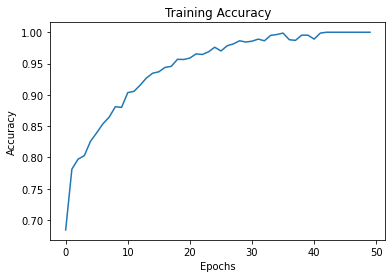

In [18]:
epoch = np.arange(EPOCHS)
plt.plot(epoch, acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [19]:
eval_score = model.evaluate(X_test, y_test)
print("Test loss:", eval_score[0])
print("Test accuracy:", eval_score[1])

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


24/24 [==============================] - 1s 16ms/step - loss: 0.3103 - accuracy: 0.9535
Test loss: 0.31027594208717346
Test accuracy: 0.9535192847251892
